<a href="https://colab.research.google.com/github/aritarodriguez/geospatial_point_analysis/blob/main/programming_supplement_uchicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1710555732.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly_union = poly_gdf.unary_union


{'dbscan_clusters': 7, 'top_cluster_sizes': {0: 368, 4: 75, 1: 70}}


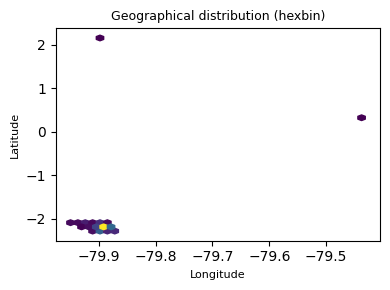

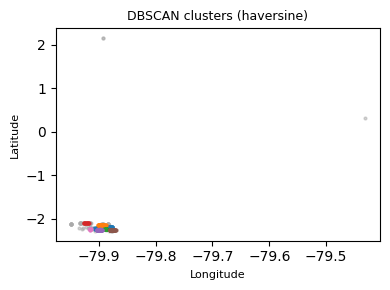

Interactive map saved as 'map_validation.html' (open in a browser).
{'rows_input': 725, 'rows_dropped_no_coords': 0}
  INSIDE_POLYGON  COUNTS
0             No       3
1            Yes     722


In [ ]:
# === Geospatial validation ===
import pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 1) Ingest (CSV preferred; Excel fallback)
try:
    df = pd.read_csv("TALLER_FINAL.csv")
except FileNotFoundError:
    df = pd.read_excel("TALLER FINAL.xlsx", sheet_name="Guayaquil")

# Clean headers; detect lat/lon
df.columns = df.columns.str.strip().str.upper().str.replace("\n"," ", regex=False)
col_lat = [c for c in df.columns if "LAT" in c][0]
col_lon = [c for c in df.columns if "LON" in c][0]
df = df.rename(columns={col_lat:"LATITUDE", col_lon:"LONGITUDE"})

# 2) Dtype management: numeric + optional categorical/date
df["LATITUDE"]  = pd.to_numeric(df["LATITUDE"],  errors="coerce")
df["LONGITUDE"] = pd.to_numeric(df["LONGITUDE"], errors="coerce")
if "SECTOR" in df.columns: df["SECTOR"] = df["SECTOR"].astype("category")
for dc in ("FECHA","DATE","FECHA_VISITA","VISIT_DATE"):
    if dc in df.columns: df[dc] = pd.to_datetime(df[dc], errors="coerce")

n_in = len(df)
df = df.dropna(subset=["LATITUDE","LONGITUDE"]).copy()
dropped = n_in - len(df)

# 3) Geo conversion
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"]), crs="EPSG:4326")

# 4) Polygon (KML) + unify
poly_gdf = gpd.read_file("Guayaquil.kml", driver="KML").to_crs("EPSG:4326")
poly_gdf = poly_gdf[poly_gdf.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
poly_union = poly_gdf.unary_union

# 5) Define function to test whether each point lies within the polygon
def point_in_poly(point, polygon):
    """Return 'Yes' if point is inside or on boundary; else 'No'."""
    return "Yes" if polygon.covers(point) else "No"

gdf["INSIDE_POLYGON"] = gdf.geometry.apply(lambda p: point_in_poly(p, poly_union))

# 6) Wrangle / summary
counts_in_out = (gdf.groupby("INSIDE_POLYGON").size()
                   .rename("COUNTS").reset_index())

# 6b) Unsupervised clustering with DBSCAN (haversine distance)
R_km = 6371.0088                    # Earth radius (km)
eps_km = 0.5                        # neighborhood radius in km
coords_rad = np.radians(gdf[["LATITUDE","LONGITUDE"]].to_numpy())

db = DBSCAN(eps=eps_km / R_km, min_samples=10, metric="haversine").fit(coords_rad)
gdf["CLUSTER_DBSCAN"] = db.labels_

# Compact summary
labels = gdf["CLUSTER_DBSCAN"]
n_clusters = labels[labels != -1].nunique()
top_sizes = (labels[labels != -1].value_counts().head(3).to_dict())
print({"dbscan_clusters": int(n_clusters), "top_cluster_sizes": top_sizes})

# 7) Static visualization (hexbin density)
plt.figure(figsize=(4,3))
plt.hexbin(gdf["LONGITUDE"], gdf["LATITUDE"], gridsize=40, mincnt=1)
plt.title("Geographical distribution (hexbin)", fontsize=9)
plt.xlabel("Longitude", fontsize=8); plt.ylabel("Latitude", fontsize=8)
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
palette = {-1: "#AAAAAA"}  # noise in gray
for k in sorted(gdf["CLUSTER_DBSCAN"].unique()):
    sel = gdf["CLUSTER_DBSCAN"] == k
    c = palette.get(k, None)  # None lets matplotlib choose distinct colors
    plt.scatter(gdf.loc[sel,"LONGITUDE"], gdf.loc[sel,"LATITUDE"], s=4, alpha=0.5, c=c)
plt.title("DBSCAN clusters (haversine)", fontsize=9)
plt.xlabel("Longitude", fontsize=8); plt.ylabel("Latitude", fontsize=8)
plt.tight_layout(); plt.show()


# 8) Exports (results + interactive map saved to HTML)
out_points = (gdf.drop(columns=["geometry"])
                .rename(columns={"LATITUDE":"Latitude","LONGITUDE":"Longitude"}))
out_points.to_csv("points_with_flag.csv", index=False)

# Define marker colors for inside vs. outside points
colors = {"Yes": "#2ca02c", "No": "#d62728"}  # green for inside, red for outside

import folium
m = folium.Map(location=[gdf["LATITUDE"].mean(), gdf["LONGITUDE"].mean()],
               zoom_start=12, tiles="CartoDB positron")
folium.GeoJson(poly_union, name="Guayaquil Polygon",
               style_function=lambda x: {"color":"#1f77b4","weight":2,"fillOpacity":0.05}).add_to(m)
for _, r in gdf.iterrows():
    folium.CircleMarker([r["LATITUDE"], r["LONGITUDE"]],
                        radius=4, color=colors.get(r["INSIDE_POLYGON"],"#888"),
                        fill=True, fill_opacity=0.8).add_to(m)
m.save("map_validation.html")
print("Interactive map saved as 'map_validation.html' (open in a browser).")

# 9) Tiny printed summary (kept concise for 2 pages)
print({"rows_input": n_in, "rows_dropped_no_coords": dropped})
print(counts_in_out)
